In [1]:
import pandas as pd
pd.__version__

'0.22.0'

In [2]:
%matplotlib inline
#%matplotlib notebook
from sklearn import datasets, linear_model
import numpy as np
import matplotlib.pyplot as plt
# Set plot font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams['font.size'] = 16

### String Constants

In [3]:
df_suffix = 'Df.pkl'
byTrial_suffix = 'DfByTrial.pkl'
overall_suffix = 'OverallStatsDf.pkl'
summary_suffix = 'SummaryText.txt'
date_prefix = '180120'
outdir_prefix = 'graphs/'
outdir_prefix_std_error = 'graphsWithStandardErrorBars/'

BINARY = "B"
NORMAL = "N"

BANDIT = "Bandit Sampling"
PRIOR_BTW = "Prior between"
UNIFORM = "Uniform Sampling"

bb_prefix = "bbSoftmax"
better_infix = "PreferBetterActions"
worse_infix = "PreferWorseActions"
es_infix = "ES"
bb_infix = "BB"

ng_prefix = "ngSoftmax"
ng_infix = "NG"

prefer_infix_lst = (better_infix, worse_infix)
preference_label = ("Higher-earlier", "Higher-later")

# (Optimal, softmax 0.0 - 0.5)
colors = ('#fed976','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84')
# (Optimal, Prior Btw, Prior Btw Regression, Uniform, Uniform Regression)
colors_line = ('#a6cee3','#1f78b4','#fc8d62','#fb9a99','#018571')

### Simulation Settings

In [15]:
effectSizeB = 0.3
effectSizeN = 0.5
softmaxRange = np.arange(0.0, 0.6, 0.1)
mean_names_lst = []
std_names_lst = []
for i in range(len(softmaxRange)):
    mean_names_lst.append("Softmax "+str(round(softmaxRange[i],1)))
    std_names_lst.append("softmax "+str(round(softmaxRange[i],1))+" std")

In [5]:
def scale_normal_rewards(x, good_arm, bad_arm):
    return ((x - (bad_arm)) / (good_arm - (bad_arm)))

In [6]:
import ast
def get_arms(softmax, reward_type):
    if reward_type == BINARY:
        effect_size = effectSizeB
        summary = open(bb_prefix+str(softmax)+prefer_infix_lst[0]+es_infix+str(effect_size)+bb_infix+str(effect_size)+summary_suffix)
    elif reward_type == NORMAL:
        effect_size = effectSizeN
        summary = open(ng_prefix+str(softmax)+prefer_infix_lst[0]+es_infix+str(effect_size)+ng_infix+str(effect_size)+summary_suffix)

    for line in summary:
        if line.startswith("Arm stats:"):
            arms = line.split(':')[1].strip()
            return ast.literal_eval(arms)[:2]

In [7]:
def get_avg_col_per_num_steps_dfs(preference_infix, reward_type, col, stdError=False):
    df_lst = []
    if reward_type == BINARY:
        effect_size = str(effectSizeB)
        prefix = bb_prefix
        infix = bb_infix
    elif reward_type == NORMAL:
        effect_size = str(effectSizeN)
        prefix = ng_prefix
        infix = ng_infix
    
    for i in range(len(softmaxRange)):
        softmax = softmaxRange[i]
        df = pd.read_pickle(prefix+str(softmax)+preference_infix+es_infix+str(effect_size)+\
                            infix+str(effect_size)+df_suffix)
        df_lst.append(df)
        
    avg_lst = []
    std_lst = []
    for i in range(len(df_lst)):
        df = df_lst[i]
        
        gp = df[['num_steps', col]].groupby('num_steps')
        
        avg = gp.mean().reset_index().rename(columns={col: mean_names_lst[i]})
        avg_lst.append(avg)
        std = gp.std().reset_index().rename(columns={col: std_names_lst[i]})
        if (stdError):
            count = gp.size().reset_index(name='counts')
            std[std_names_lst[i]] = std[std_names_lst[i]] / np.sqrt(count['counts'])

        std_lst.append(std)

    result = pd.merge(avg_lst[0], avg_lst[1], how='outer', on=['num_steps'])
    for i in range(2, len(avg_lst)):
        result = pd.merge(result, avg_lst[i], how='outer', on=['num_steps'])
    for i in range(len(std_lst)):
        result = pd.merge(result, std_lst[i], how='outer', on=['num_steps'])
        
    result = result.reset_index(drop=True).set_index('num_steps')

    return result

In [8]:
def get_avg_col_per_step_dfs(preference_infix, reward_type, col, stdError=False):
    avg_total_rewards = get_avg_col_per_num_steps_dfs(preference_infix, reward_type, col, stdError=stdError)
    for column in avg_total_rewards.columns:
        # Update mean and std
        avg_total_rewards[column] = avg_total_rewards[column] / avg_total_rewards.index

        # Apply scaling if normal rewards
        if col == "total_reward" and reward_type == NORMAL:
            if "std" not in column:
                # scale avg
                avg_total_rewards[column] = avg_total_rewards[column].\
                apply(scale_normal_rewards, args=(max(get_arms(softmaxRange[0], NORMAL)), \
                                                  min(get_arms(softmaxRange[0], NORMAL))))
            else: 
                # scale std
                avg_total_rewards[column] = avg_total_rewards[column].\
                apply(lambda x: \
                      x / (max(get_arms(softmaxRange[0], NORMAL)) - min(get_arms(softmaxRange[0], NORMAL))))

    return avg_total_rewards

In [9]:
get_avg_col_per_step_dfs(worse_infix, BINARY, 'total_reward', stdError=True)

,Softmax 0.0,Softmax 0.1,Softmax 0.2,Softmax 0.3,Softmax 0.4,Softmax 0.5,softmax 0.0 std,softmax 0.1 std,softmax 0.2 std,softmax 0.3 std,softmax 0.4 std,softmax 0.5 std
num_steps,,,,,,,,,,,,
44,0.588636,0.588955,0.596000,0.592318,0.587091,0.588364,0.003776,0.003947,0.003899,0.003933,0.003750,0.003812
88,0.608523,0.607886,0.609477,0.604318,0.613886,0.610705,0.002679,0.002785,0.002765,0.002773,0.002625,0.002657
176,0.623148,0.625386,0.625023,0.622909,0.627557,0.630727,0.001937,0.001846,0.001928,0.001904,0.001768,0.001766
352,0.632653,0.636710,0.635250,0.636807,0.635182,0.636727,0.001350,0.001243,0.001279,0.001243,0.001279,0.001231


# Average Reward Gain at Step

In [10]:
def plot_avg_reward_gain_at_m_single(reward_type, legend_anchor=(1.4, 0.8), stdError=False):
    df = pd.DataFrame(dtype=float)
    if reward_type == BINARY:
        effectSize = effectSizeB
    elif reward_type == NORMAL:
        effectSize = effectSizeN
    for i in range(len(prefer_infix_lst)):
        df_m = get_avg_col_per_step_dfs(prefer_infix_lst[i], reward_type, "total_reward", stdError=stdError).iloc[1:2]
        if reward_type == BINARY:
            df_m["Optimal Reward"] = max(get_arms(softmaxRange[0], reward_type))
        else:
            good_arm = max(get_arms(softmaxRange[0], reward_type))
            bad_arm = min(get_arms(softmaxRange[0], reward_type))
            df_m["Optimal Reward"] = scale_normal_rewards(good_arm, good_arm, bad_arm)

        df_m["or_std"] = pd.Series()

        df = pd.concat([df, df_m])

    m = df[["Optimal Reward"]+list(mean_names_lst)]
    std = df[list(std_names_lst)+['or_std']]
    std.columns = list(mean_names_lst)+['Optimal Reward']
    ax = m.plot.bar(yerr=std, rot=0, color=colors)

    ax.set_xlabel("")
    xticks = []

    ax.set_xticklabels(preference_label)
    ax.set_ylabel("Rewards")
    
    ax.legend(bbox_to_anchor=legend_anchor)

    if reward_type == BINARY:
        ax.set_title("Average Reward Gain per Step in m Steps (Binary Reward)")
    elif reward_type == NORMAL:
        ax.set_title("Average Reward Gain per Step in m Steps (Scaled, Normal Reward)")
    return ax

### Binary Rewards

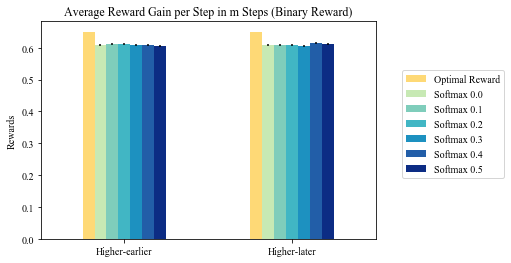

In [11]:
ax = plot_avg_reward_gain_at_m_single(BINARY, stdError=True)

### Normal Rewards

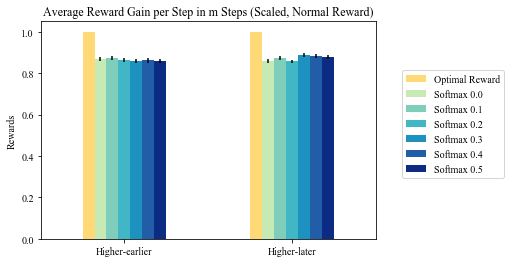

In [12]:
ax = plot_avg_reward_gain_at_m_single(NORMAL, stdError=True)

### Combine Plots

In [30]:
def plot_avg_reward_gain_at_m(reward_type, ax, ylabel="", hasLegend=True, legend_anchor=(0.55, 1.55), stdError=False):
    df = pd.DataFrame(dtype=float)
    import pickle
    if reward_type == BINARY:
        effectSize = effectSizeB
        df = pd.read_pickle('180120ReorderedBinaryRewardTwoArmsDiffer.pkl')
    elif reward_type == NORMAL:
        effectSize = effectSizeN
        df = pd.read_pickle('180120ReorderedNormalRewardTwoArmsDiffer.pkl')

#     for i in range(len(prefer_infix_lst)):
#         df_m = get_avg_col_per_step_dfs(prefer_infix_lst[i], reward_type, "total_reward", stdError=stdError).iloc[1:2]
#         if reward_type == BINARY:
#             df_m["Optimal Reward"] = max(get_arms(softmaxRange[0], reward_type))
#         else:
#             good_arm = max(get_arms(softmaxRange[0], reward_type))
#             bad_arm = min(get_arms(softmaxRange[0], reward_type))
#             df_m["Optimal Reward"] = scale_normal_rewards(good_arm, good_arm, bad_arm)

#         df_m["or_std"] = pd.Series()

#         df = pd.concat([df, df_m])

    m = df[["Optimal Reward"]+list(mean_names_lst)]
    std = df[list(std_names_lst)+['or_std']]
    std.columns = list(mean_names_lst)+['Optimal Reward']
    m.plot.bar(ax=ax, yerr=std, rot=0, color=colors)

    ax.set_xlabel("")
    ax.set_xticklabels(preference_label)
    ax.set_ylabel(ylabel)
    
    if hasLegend:
        ax.legend(bbox_to_anchor=legend_anchor)
    else:
        ax.legend_.remove()

    if reward_type == BINARY:
        ax.set_title("Binary Reward")
    elif reward_type == NORMAL:
        ax.set_title("Scaled, Normal Reward")
    return ax

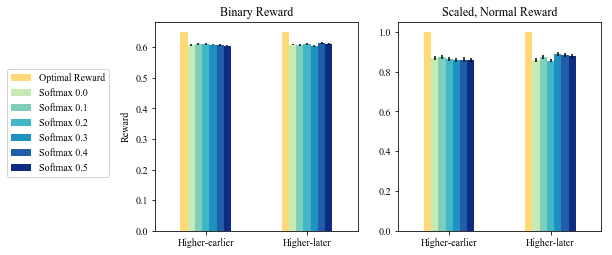

In [31]:
figure = plt.figure(figsize = (8, 4))
stdError = True

# Bar for Binary Reward 
ax = figure.add_subplot(1, 2, 1)
plot_avg_reward_gain_at_m(BINARY, ax, ylabel="Reward", legend_anchor=(-0.2, 0.8), stdError=stdError)

# Bar for Normal Reward 
ax = figure.add_subplot(1, 2, 2)
plot_avg_reward_gain_at_m(NORMAL, ax, hasLegend=False, stdError=stdError)

# Set super title for all subgraphs
plt.subplots_adjust(top=0.85)
if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
figure.savefig(outdir+date_prefix+'AvgRewardGainAtStepM.pdf', bbox_inches='tight')

# Power

In [9]:
def get_power_by_steps(dfs_by_trial, columns, alpha = 0.05):
    '''
    df_by_trial is a data frame with information about each run,
    as calculated by calculate_by_trial_statistics_from_sims.
    This function returns the continuous evaluation of power at every step until 4m steps,
    and the power snapshot at step 0.5m, m, 2m and 4m for all effect sizes.
    Power is calculated as what proportion of the p-values were below alpha at that point.
    '''
    unique_sample_sizes = dfs_by_trial[0].num_steps.unique()

    power_df = pd.DataFrame(columns=columns)
    power_all_steps = []
    for i in range(len(unique_sample_sizes)):
        cur_n = unique_sample_sizes[i]
        power_df.loc[i,columns[0]] = cur_n
        # Add bandit and uniform sampling lines 
        j = 1
        for df in dfs_by_trial:
            cur_df = df[df['num_steps'] == cur_n]
            statistic_list = []
            for trial in range(10, cur_n):
                avg_stat = np.sum(cur_df[cur_df['trial'] == trial]['pvalue'] < alpha) \
                            / len(cur_df[cur_df['trial'] == trial])
                statistic_list.append(avg_stat)
            
            if cur_n == unique_sample_sizes[-1]:
                power_all_steps.append(statistic_list[:])
            
            power_df.iloc[i, j] = statistic_list[-1]
            j+=1
    return power_all_steps, power_df

In [10]:
def plot_power_bar(df, x_col, y_col, ax, setLegend, title, legend_anchor=(0.5, 1.7), ylabel="", \
                   hline_value=None, hline_label=None, color=colors):
    x = df[x_col]
    y = df[y_col]

    y.plot.bar(ax=ax, rot=0, color=color[1:])
    plt.xlabel("Step, m="+str(x.iloc[1, 0]))
    ax.set_xticklabels(['0.5m', 'm', '2m', '4m'])
    # set visualization range to 0-1
    ax.set_ylim(0.0, 1.0)
    
    legend = y_col
    
    if hline_value!=None:
        ax.axhline(hline_value, color=color[0], linestyle='dashed', linewidth=2)
        legend.insert(0, hline_label)

    plt.title(title)
    
    if setLegend:
        ax.legend(legend, ncol=3, bbox_to_anchor=legend_anchor)
        ax.set_ylabel(ylabel)
    else:
        ax.legend_.remove()

### Binary Reward

In [17]:
binary_power = []
binary_power_all_steps = []
effect_size = str(effectSizeB)
prefix = bb_prefix
infix = bb_infix
for i in range(len(prefer_infix_lst)):
    df_lst = []
    columns = list(mean_names_lst)
    preference_infix = prefer_infix_lst[i]
    
    for i in range(len(softmaxRange)):
        softmax = softmaxRange[i]
        df = pd.read_pickle(prefix+str(softmax)+preference_infix+es_infix+str(effect_size)+\
                            infix+str(effect_size)+byTrial_suffix)
        df_lst.append(df)
        
    power_all_steps, power_df = get_power_by_steps(df_lst, ["num_steps"] + list(mean_names_lst))
    binary_power.append(power_df)
    binary_power_all_steps.append(power_all_steps)
    
import pickle
with open(date_prefix+'ReorderedBinaryPowerTwoArmsDiffer.pkl', 'wb') as f:
    pickle.dump(binary_power, f)
    
with open(date_prefix+'ReorderedBinaryPowerAllStepsTwoArmsDiffer.pkl', 'wb') as f:
    pickle.dump(binary_power_all_steps, f)

In [11]:
# Load from pickle
import pickle
binary_power = pd.read_pickle(date_prefix+'ReorderedBinaryPowerTwoArmsDiffer.pkl')
binary_power_all_steps = pd.read_pickle(date_prefix+'ReorderedBinaryPowerAllStepsTwoArmsDiffer.pkl')
mean_names_lst

In [16]:
print(mean_names_lst)
print(binary_power)

['Softmax 0.0', 'Softmax 0.1', 'Softmax 0.2', 'Softmax 0.3', 'Softmax 0.4', 'Softmax 0.5']
[  num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
0        44       0.338       0.294        0.23       0.222       0.166   
1        88       0.606       0.496       0.468       0.338       0.282   
2       176       0.798       0.698       0.596        0.48       0.416   
3       352       0.936       0.882       0.802       0.706       0.624   

  Softmax 0.5  
0       0.166  
1       0.314  
2        0.38  
3       0.556  ,   num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
0        44        0.35        0.36       0.434       0.502       0.556   
1        88        0.53       0.636       0.708         0.8       0.822   
2       176        0.78       0.852       0.898        0.92       0.958   
3       352       0.928        0.95       0.968       0.978       0.988   

  Softmax 0.5  
0       0.612  
1       0.866  
2       0.958  
3       0.9

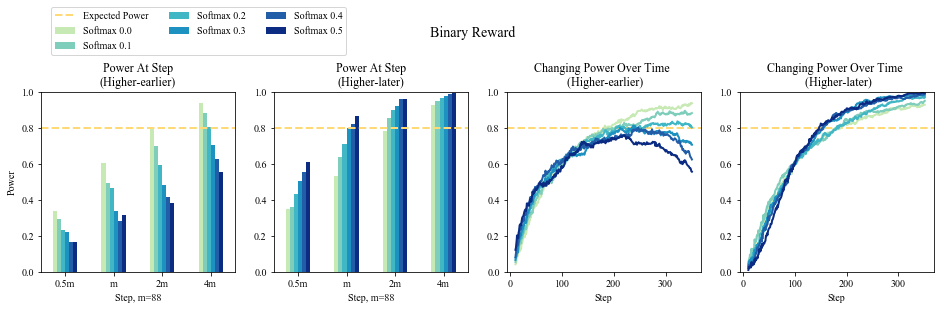

In [17]:
figure = plt.figure(figsize = (16, 4))
setLegend = True
# Bar graph for power at step m
for i in range(len(prefer_infix_lst)):
    ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 1)

    avg_power_binary = binary_power[i]
    plot_power_bar(avg_power_binary, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Power At Step\n("+preference_label[i]+")",\
                   legend_anchor=(1.6, 1.5), ylabel="Power", hline_value=0.8, hline_label="Expected Power")
    setLegend = False
    
# Line graph for power per step
for i in range(len(prefer_infix_lst)):
    ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 3)
    ax.axhline(0.8, color=colors[0], linestyle='dashed', linewidth=2)
    j = 1
    all_steps = binary_power_all_steps[i]
    for p in all_steps:
        x = range(10, len(p)+10)
        ax.plot(x, p, lw=2, color=colors[j])
        j+=1
    ax.set_xlabel('Step')
    # set visualization range to 0-1
    ax.set_ylim(0.0, 1.0)
    
    plt.title("Changing Power Over Time \n ("+preference_label[i]+")")

figure.suptitle("Binary Reward",  fontsize=14)
plt.subplots_adjust(top=0.75)
figure.savefig(outdir_prefix+date_prefix+'MeasuredPowerPerStepBinary.pdf', bbox_inches='tight')

### Normal Reward

In [19]:
normal_power = []
normal_power_all_steps = []
effect_size = str(effectSizeN)
prefix = ng_prefix
infix = ng_infix

for i in range(len(prefer_infix_lst)):
    df_lst = []
    columns = list(mean_names_lst)
    preference_infix = prefer_infix_lst[i]
    
    for i in range(len(softmaxRange)):
        softmax = softmaxRange[i]
        df = pd.read_pickle(prefix+str(softmax)+preference_infix+es_infix+str(effect_size)+\
                            infix+str(effect_size)+byTrial_suffix)
        df_lst.append(df)
        
    power_all_steps, power_df = get_power_by_steps(df_lst, ["num_steps"]+list(mean_names_lst))
    normal_power.append(power_df)
    normal_power_all_steps.append(power_all_steps)

import pickle
with open(date_prefix+'ReorderedNormalPowerTwoArmsDiffer.pkl', 'wb') as f:
    pickle.dump(normal_power, f)
    
with open(date_prefix+'ReorderedNormalPowerAllStepsTwoArmsDiffer.pkl', 'wb') as f:
    pickle.dump(normal_power_all_steps, f)

In [18]:
# Load from pickle
import pickle
normal_power = pd.read_pickle(date_prefix+'ReorderedNormalPowerTwoArmsDiffer.pkl')
normal_power_all_steps = pd.read_pickle(date_prefix+'ReorderedNormalPowerAllStepsTwoArmsDiffer.pkl')

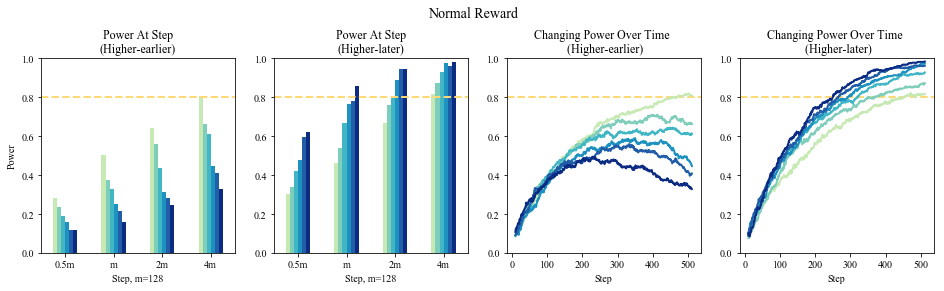

In [19]:
figure = plt.figure(figsize = (16, 4))
setLegend = False
# Bar graph for power at step m
for i in range(len(prefer_infix_lst)):
    ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 1)
    if (i == 0):
        ax.set_ylabel("Power")
    avg_power_normal = normal_power[i]
    plot_power_bar(avg_power_normal, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Power At Step\n("+preference_label[i]+")", \
                   ylabel="Power", hline_value=0.8, hline_label="Expected Power")
    
# Line graph for power per step
for i in range(len(prefer_infix_lst)):
    ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 3)
    ax.axhline(0.8, color=colors[0], linestyle='dashed', linewidth=2)
    j = 1
    all_steps = normal_power_all_steps[i]
    for p in all_steps:
        x = range(10, len(p)+10)
        ax.plot(x, p, lw=2, color=colors[j])
        j+=1
    ax.set_xlabel('Step')
    # set visualization range to 0-1
    ax.set_ylim(0.0, 1.0)
    
    plt.title("Changing Power Over Time \n ("+preference_label[i]+")")

figure.suptitle("Normal Reward",  fontsize=14)
plt.subplots_adjust(top=0.8)
figure.savefig(outdir_prefix+date_prefix+'MeasuredPowerPerStepNormal.pdf', bbox_inches='tight')

# Estimate of the worse condition

In [21]:
get_avg_col_per_num_steps_dfs(worse_infix, BINARY, 'mean_2')

,Softmax 0.0,Softmax 0.1,Softmax 0.2,Softmax 0.3,Softmax 0.4,Softmax 0.5,softmax 0.0 std,softmax 0.1 std,softmax 0.2 std,softmax 0.3 std,softmax 0.4 std,softmax 0.5 std
num_steps,,,,,,,,,,,,
44,0.255321,0.269742,0.254014,0.240813,0.226673,0.203604,0.177324,0.183579,0.182590,0.178909,0.172298,0.173105
88,0.277031,0.266261,0.244947,0.221829,0.222236,0.191970,0.165597,0.158887,0.165988,0.148216,0.150555,0.146149
176,0.285856,0.254315,0.238870,0.223112,0.200881,0.184048,0.146760,0.150154,0.142556,0.146430,0.139457,0.130451
352,0.287067,0.254094,0.250355,0.220141,0.206292,0.185971,0.135229,0.145097,0.131676,0.124359,0.122341,0.116574


In [22]:
def plot_worse_arm_estimate_at_m(reward_type, ax, ylabel="", hasLegend=True, legend_anchor=(0.55, 1.55), color=colors, stdError=False):
    df = pd.DataFrame(dtype=float)
    if reward_type == BINARY:
        effectSize = effectSizeB
    elif reward_type == NORMAL:
        effectSize = effectSizeN
#     for i in range(len(prefer_infix_lst)):
#         df_m = get_avg_col_per_num_steps_dfs(prefer_infix_lst[i], reward_type, 'mean_2', stdError).iloc[1:2]
#         if reward_type == BINARY:
#             actual_reward = min(get_arms(softmaxRange[0], reward_type))
#         else:
#             good_arm = max(get_arms(softmaxRange[0], reward_type))
#             bad_arm = min(get_arms(softmaxRange[0], reward_type))
#             actual_reward = scale_normal_rewards(bad_arm, good_arm, bad_arm)

#         df_m["or_std"] = pd.Series()

#         df = pd.concat([df, df_m])
#     import pickle
#     if reward_type == BINARY:
#         with open(date_prefix+'BinaryWorseArmEstimate.pkl', 'wb') as f:
#             pickle.dump(df, f)
#     elif reward_type == NORMAL:
#         with open(date_prefix+'NormalWorseArmEstimate.pkl', 'wb') as f:
#             pickle.dump(df, f)
    import pickle
    if reward_type == BINARY:
        actual_reward = 0.35
        df = pd.read_pickle(date_prefix+'BinaryWorseArmEstimate.pkl')
    elif reward_type == NORMAL:
        actual_reward = -0.5
        df = pd.read_pickle(date_prefix+'NormalWorseArmEstimate.pkl')
    m = df[list(mean_names_lst)]
    std = df[list(std_names_lst)]
    std.columns = list(mean_names_lst)
    m.plot.bar(ax=ax, yerr=std, rot=0, color=colors[1:])
    ax.axhline(actual_reward, color=color[0], linestyle='dashed', linewidth=2)
    
    legend = list(mean_names_lst)
    legend.insert(0, "Actual Reward")

    
    ax.set_xlabel("")
    ax.set_xticklabels(preference_label)
    ax.set_ylabel(ylabel)
    
    if hasLegend:
        ax.legend(legend, bbox_to_anchor=legend_anchor)
    else:
        ax.legend_.remove()

    if reward_type == BINARY:
        ax.set_title("Binary Reward")
    elif reward_type == NORMAL:
        ax.set_title("Scaled, Normal Reward")
    return ax

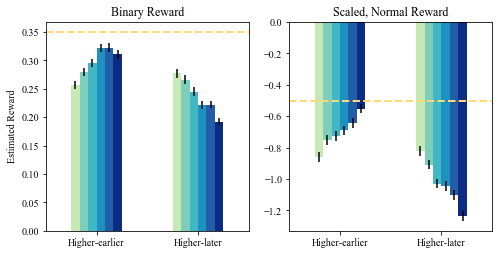

In [25]:
figure = plt.figure(figsize = (8, 4))
stdError = True

# Bar for Binary Reward 
ax = figure.add_subplot(1, 2, 1)
plot_worse_arm_estimate_at_m(BINARY, ax, hasLegend=False, ylabel="Estimated Reward", legend_anchor=(-0.1, 0.8), stdError=stdError)

# Bar for Normal Reward 
ax = figure.add_subplot(1, 2, 2)
plot_worse_arm_estimate_at_m(NORMAL, ax, hasLegend=False, stdError=stdError)

# Set super title for all subgraphs
plt.subplots_adjust(top=0.85)
if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
figure.savefig(outdir+date_prefix+'WorseArmEstimateAtStepM.pdf', bbox_inches='tight')
# with open(date_prefix+'AxisForArmEstimates.pkl', 'wb') as f:
#     pickle.dump(figure, f)

In [29]:
# figure = pickle.load(open(date_prefix+'AxisForArmEstimates.pkl','rb')) 
# # figure.show()

AttributeError: 'module' object has no attribute 'new_figure_manager_given_figure'